In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from utils_preproc import *

C:\Users\Susana\Anaconda2\envs\py3k\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Descriptors calculation

For each event, containing several pairs of stations, we calculate the following descriptors:

### 1. Global descriptors

| name      | description   |
|:-:|:-:    |
|year       | Year (2013-2014)|
|doy        | Time of year (1-365)|
|prn       | Satellite PRN|
|hh         | Time of day (0. - 24.)|
|min_grad   | Maximum gradient |
|mean_grad   | Maximum gradient |
|std_grad   | Maximum gradient |
|n_stations       | Number of stations |
|n_pairs    | Number of pairs |
|el_deg         | Elevation in degrees |
|gradient       | Maximum gradient |


### 2. Individual curve descriptors

For each curve the *delay* and *first difference* descriptors are calculated, and the mean, std, min and max of the curves descriptors are calculated as general descriptors. 

For example: For an event detected by 5 stations, the descriptor *i_range* is calculated for each station in the event, and event descriptors are *i_range_min*, *i_range_max*, *i_range_mean*, *i_range_std* among the 5 stations stations.

#### 2.1. Delay descriptors

| name  | description  | normalization  |
|:-:|:-:|:-:|
|i_range| Maximum phase delay minus Minimum phase delay||
|n_epochs|Number of epochs ||
|roti_min|Min of scintillation index: a ROTI-like indicator (*) ||
|roti_mean|Mean of scintillation index: a ROTI-like indicator||
|roti_max|Max of scintillation index: a ROTI-like indicator||
|roti_std|Std of scintillation index: a ROTI-like indicator||
|n_outliers_ma|Number of outliers from Moving Average method||
|n_outliers_pf|Number of outliers from Polynomial fit method||

(*) Since iono_delay is proportional to TEC, we will 
use iono delay and obtain a ROTI-like index as (calculated over 
a rolling window):

$$SROT = \frac{\Delta I_{delay}}{\Delta t}$$

$$SROTI = \sqrt{<ROT^2> - <ROT>^2 }$$

#### 2.2. First difference descriptors

**diff**: for each station, array containing the difference between consecutive phase delay values station

| name  | description  | normalization |
|:-:|:-:|:-:|
|diff_max| Max diff value during all the event ||
|diff_std| Std diff value during all the event ||
|diff_outliers| Number of points out of +/- n sigmas || 	 	 	 	 	 	 	 	 	 	

## Load the descriptors previously calculated

In [3]:
base_dir = 'D://VBox/data/itm_ecuador/visualization/'
plots_dir = {2013 : base_dir+'Plots2013', 2014 : base_dir+'Plots2014'}

# Load events manual classification 
ev_class = pd.read_csv('D://phd/data/labels.csv')

# Load descriptors 
desc_file = 'D://phd/data/desc_layer_1.h5'

x, y = load_descriptors_layer_1(desc_file)

x_train_raw, x_test_raw, y_train, y_test = split_train_test(x, y, test_size=0.0)
x_train_sc, _ = scale(x_train_raw)
x_train, _ = pca_transform(x_train_sc, 10)

Dataset size (17504, 55)
Train size:	 (17504, 55)
Test size:	 (0, 55)
[0.2659021  0.48004627 0.57343503 0.64731905 0.6961086  0.73276251
 0.76591791 0.78859017 0.8096262  0.82947542 0.84654351 0.8617597
 0.87654179 0.89090867 0.90346773 0.91431074 0.9250479  0.93480691
 0.94380026 0.95113944 0.95697158 0.96216056 0.96692101 0.97157299
 0.9755773  0.97944317 0.98276308 0.98540998 0.98756101 0.98921485
 0.99060678 0.99180901 0.99281272 0.99372963 0.99439603 0.99501728
 0.99554386 0.99602336 0.99646683 0.99687592 0.997265   0.99762435
 0.99796938 0.99830422 0.99856523 0.99879333 0.99899719 0.99918301
 0.99936564 0.9995318  0.99966386 0.99977264 0.99987455 0.99996396
 1.        ]


### Plot two random events and their features

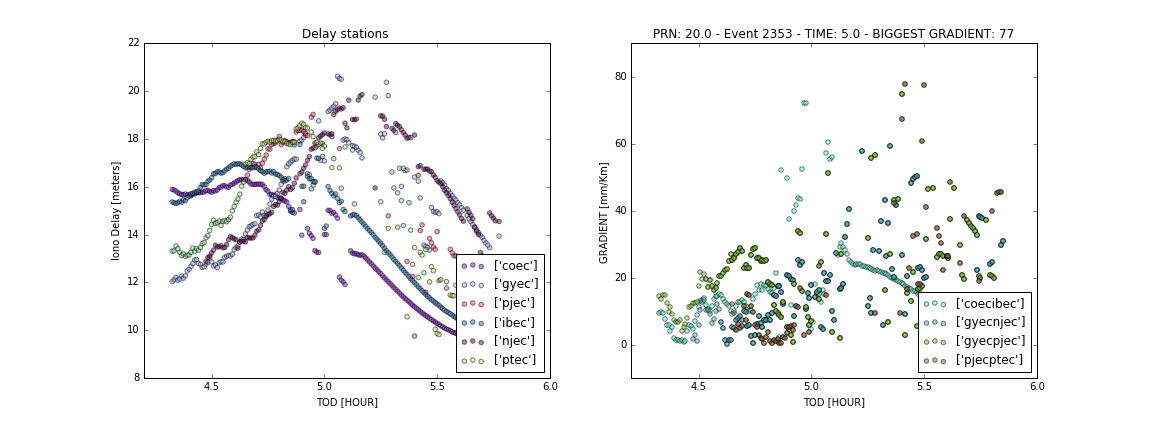

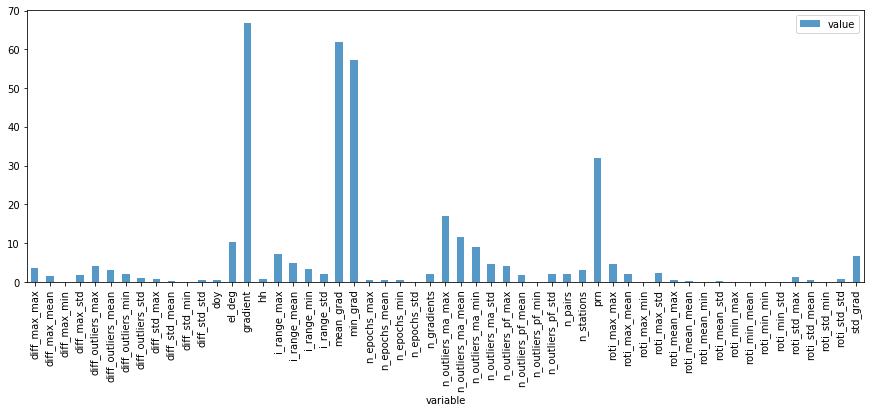

In [4]:
e_sample = y_train.sample()
eid, year = e_sample['event_id'].values[0], e_sample['year'].values[0]
features = x.loc[e_sample.index].melt()
features.set_index(["variable"],inplace=True)
display_event(plots_dir,eid,year)
features.plot(kind='bar',alpha=0.75, rot=90, figsize=(15,5));

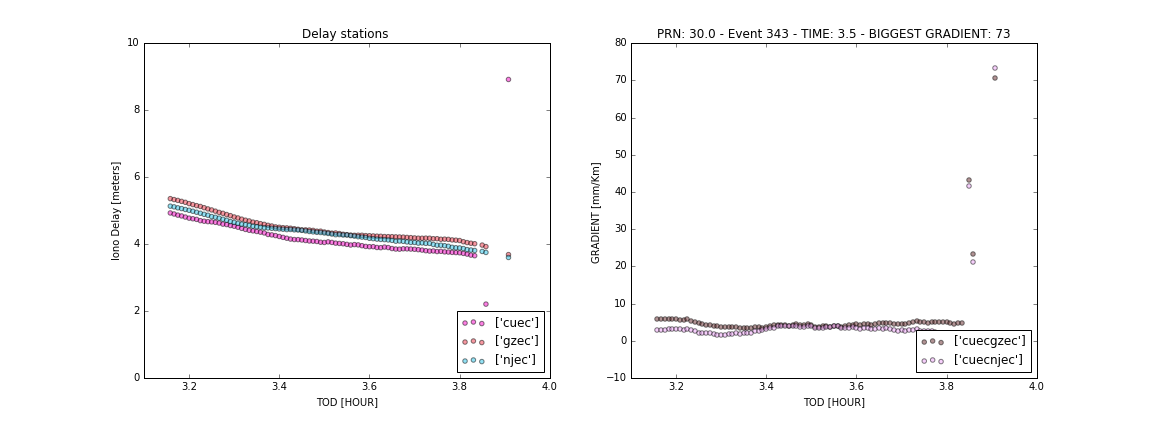

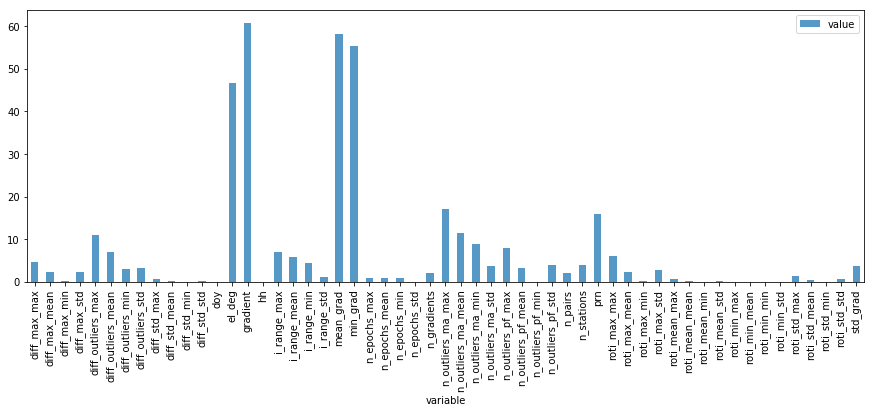

In [5]:
e_sample = y_train.sample()
eid, year = e_sample['event_id'].values[0], e_sample['year'].values[0]
features = x.loc[e_sample.index].melt()
features.set_index(["variable"],inplace=True)
display_event(plots_dir,eid,year)
features.plot(kind='bar',alpha=0.75, rot=90, figsize=(15,5));

## Clustering

Now, with the descriptors in place for the events, we will cluster them.

In [6]:
# k-means cluster analysis for 1-9 clusters                                                           
from scipy.spatial.distance import cdist
clusters = range(1,10)
meandist = []

for k in clusters:
    model    = KMeans( n_clusters = k )
    model.fit( x_train )
    labels   = model.predict( x_train )
    av_dist  = sum(np.min(cdist(x_train, 
                                model.cluster_centers_, 
                                'euclidean'), axis=1)) 
    av_dist /= x_train.shape[0]
    meandist.append( av_dist )

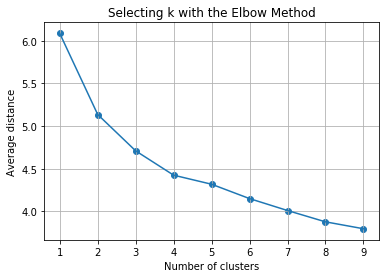

In [7]:
plt.scatter(clusters, meandist)
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')
plt.grid()
plt.show()

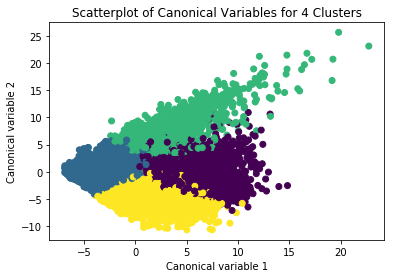

In [8]:
# Create a model and plot canonical variables
k = 4
model = KMeans(n_clusters=k)
model.fit( x_train )
labels   = model.predict( x_train )
km_classes = pd.DataFrame({"year":y_train['year'],
                       "eid" :y_train['event_id'],
                       "cluster": model.predict(x_train)})

# plot clusters
plt.scatter(x = x_train.iloc[:,0], y = x_train.iloc[:,1], c=model.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for '+str(k)+' Clusters')
plt.show()

# Compare the clusters with the known labels

In [9]:
# Compare with the events manually annotated
km_classes.head()
ev_class.columns = ['eid','valid_event','year']

compare = km_classes.merge(ev_class, how='left').fillna('Unknown')
compare.sort_values(by=['year','eid'], inplace=True)
compare_pt = compare.groupby(['cluster','valid_event'], as_index=False)['eid'].agg('count')
compare_pt.rename(columns={'eid':'n_events'}, inplace=True)
compare_pt.pivot_table(values='n_events', index='valid_event',  columns ='cluster')

cluster,0,1,2,3
valid_event,,,,
False,446.0,5468.0,1072.0,530.0
True,125.0,100.0,NaN,730.0
Unknown,2738.0,2909.0,331.0,3055.0


### Conclusions:

We clustered 17K events, out of which 8.5K have been manually flagged as False / True Positives and the remaining 9K have not been assigned a label.

- In Cluster 1 (48% of total events), 65% have been manually labelled as False events, 1% are True, and 34% have not been manually classified.
- In Cluster 2 (8%) 76% of events are False, none is True, and 24% has not been labelled.
- Clusters 0 and 3 (44%) contain a mix of True / False events, but mostly contain unlabelled events.

With fine tuning of the model (extra features, different K), if we obtain clusters with exclusive False / True events, we can rule out some groups completely and focus in the uncertain events.